# NicheCompass analysis

Here, the Resolve A1-1 data is used for NicheCompass analysis.

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import warnings
from datetime import datetime
#import gdown

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

/srv/scratch/yunseol/anaconda3/envs/nichecompass2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")

## Define Parameters

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")
#current_timestamp = '13032024_000234'

In [5]:
### Dataset ###
dataset = "sdata"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 6

### Model ###
# AnnData Keys
counts_key = "raw_counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "annotationSave"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 100
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

In [6]:
# Define paths
ga_data_folder_path = "nichecompass/data/gene_annotations"
gp_data_folder_path = "nichecompass/data/gene_programs"
so_data_folder_path = "data/sdataA1-1_optimized"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"nichecompass/artifacts"
model_folder_path = f"{artifacts_folder_path}/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/{current_timestamp}/figures"

In [7]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

## Create Prior Knowledge Gene Program (GP) Mask

Gene program: sets of genes expressed in a "spatially and temporally controlled fashion" that are defined by common tasks.

### Omnipath

Ligand-receptor

In [ ]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [86]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

CALCB_ligand_receptor_GP: {'sources': ['CALCB'], 'targets': ['CALCRL', 'RAMP1'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor', 'receptor']}


### MEBOCOST

Enzyme-sensor

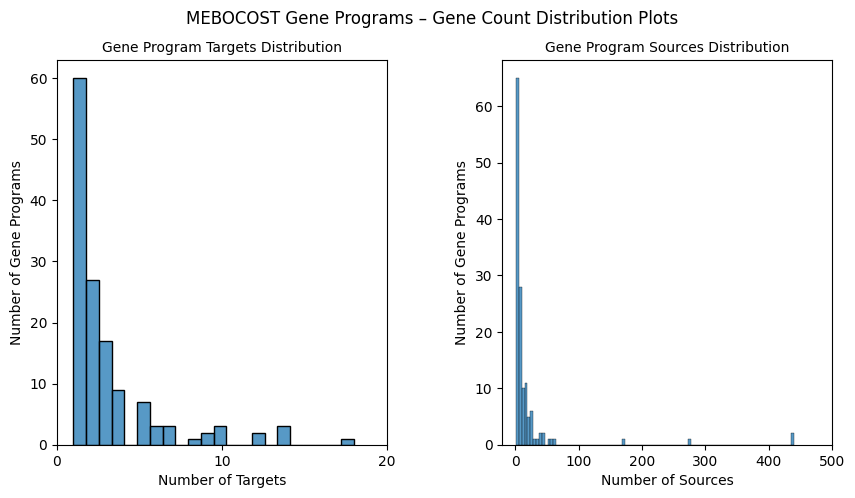

In [11]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [88]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Cytidine_metabolite_enzyme_sensor_GP: {'sources': ['AICDA', 'APOBEC3A', 'APOBEC3B', 'APOBEC3C', 'APOBEC3D', 'APOBEC3F', 'APOBEC3H', 'CDA', 'NT5C', 'NT5C1A', 'NT5C1B', 'NT5C2', 'NT5C3', 'NT5E', 'NT5M', 'UCK1', 'UCK2', 'UCKL1'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['SLC29A1', 'SLC29A2'], 'targets_categories': ['sensor', 'sensor']}


### NicheNet

Combined interaction

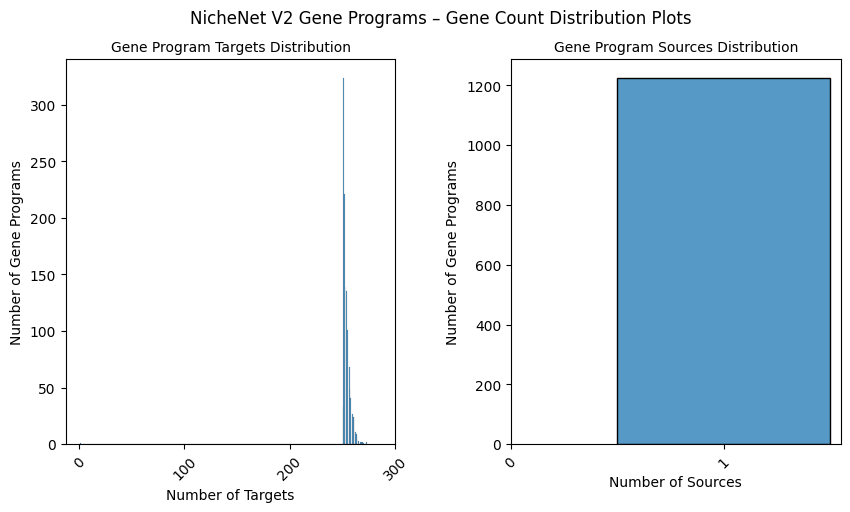

In [12]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [90]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

IL15_ligand_receptor_target_gene_GP: {'sources': ['IL15'], 'targets': ['IL15RA', 'IL2RG', 'IL2RB', 'IL2RA', 'ABCE1', 'ACP5', 'ADAM19', 'ADGRE1', 'AHR', 'AIM2', 'AKR1C3', 'ARPC5L', 'ASNS', 'BATF', 'BCL2', 'BCL2A1', 'BCL2L1', 'BHLHE40', 'BMF', 'BTN3A1', 'BZW2', 'C16orf54', 'CALHM2', 'CCDC28A', 'CCL2', 'CCL20', 'CCL3', 'CCL4', 'CCL5', 'CCND2', 'CCNG2', 'CCR1', 'CCR2', 'CCR5', 'CCR7', 'CD101', 'CD2', 'CD38', 'CD40', 'CD44', 'CD69', 'CD80', 'CD83', 'CDK6', 'CDKN1A', 'CDKN1B', 'CEBPG', 'CENPU', 'CHAC1', 'CHEK1', 'CHI3L1', 'CISH', 'CLIC3', 'CLIC4', 'CREM', 'CSF1', 'CSF2', 'CTNNAL1', 'CTPS1', 'CTSC', 'CXCL1', 'CXCL3', 'CXCL8', 'CXCR4', 'DDAH2', 'DDIT4', 'DDX21', 'DEPTOR', 'DNAJB9', 'DPEP2', 'DPP4', 'DTL', 'DUSP4', 'DUSP5', 'DUSP6', 'EBI3', 'EGR2', 'EHD1', 'ELOVL6', 'EPHA4', 'ESF1', 'ETV5', 'FAM117A', 'FAM117B', 'FCER1A', 'G0S2', 'GBP1', 'GBP5', 'GCH1', 'GEM', 'GJB2', 'GNG2', 'GPR171', 'GPR34', 'GPR82', 'GPR84', 'GZMA', 'GZMB', 'GZMH', 'H2AC6', 'HGF', 'HNRNPAB', 'HS3ST3B1', 'HSD17B11', 'HSP90AB

### Combine All and Filter

In [13]:
# Add GPs into one combined dictionary for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

In [14]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2406.
Number of gene programs after filtering and combining: 1987.


Save the GP mask for analysis later on. The saved mask can be loaded to skip the GP mask creation process.

In [15]:
# Save dictionary
# import json
# with open('nichecompass/artifacts/{}/combined_gp_dict.txt'.format(current_timestamp),'w') as fp:
#     json.dump(combined_gp_dict, fp)

In [9]:
# Load GP dictionary
# import json
# with open('/srv/scratch/yunseol/nichecompass/artifacts/05042024_143611/combined_gp_dict_mouse.txt','r') as fp:
#     combined_gp_dict = json.load(fp)

## Load Data and combine it with spatial neighbor + GP mask

In [10]:
# Read data
import spatialdata as sd
sdata = sd.read_zarr(
        f"{so_data_folder_path}/{dataset}.zarr")

adata = sdata.table
adata

AnnData object with n_obs × n_vars = 11283 × 99
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'LSEC Portal', 'LSEC Central', 'central_vein_EC45', 'stellateAll', 'stellate PeriPortal', 'stellate PeriCentral', 'FibroblastAll', 'fibroblastPortal', 'FibroblastsCentral', 'VSMC', 'capsular_fibroblasts45', 'Mesothelial cells', 'Hepatocytes', 'HepatocytesPortal', 'HepatocytesCentral', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Capsule and Central Vein Mac', 'Portal LAM macrophages', 'Monocytes', 'LECs', 'Cleanliness', 'annotation', 'Hep', 'annotationSave', 'Other immunecells', 'score_celltype_own_score_genes', 'second_score_celltype_own_score_genes', 'cleanliness_own_score_genes', 'annotation_own_score

In [11]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors,
                        percentile=80)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

In [12]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

## Model

Initialize and train the model. For Resolve data the counts_key = 'raw_counts'.

In [15]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 99, n_cat_covariates_embed_input: 0, n_hidden: 99, n_latent: 32, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 32, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 99
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 32, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 99


In [16]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 10155
Number of validation nodes: 1128
Number of training edges: 34678
Number of validation edges: 3853
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---
Epoch 1/400 |--------------------| 0.2% train_global_loss: 379589.9697; train_optim_loss: 379589.9697; val_global_loss: 349242.0391; val_optim_loss: 349242.0391
Epoch 2/400 |--------------------| 0.5% train_global_loss: 324234.9614; train_optim_loss: 324234.9614; val_global_loss: 316862.4531; val_optim_loss: 316862.4531
Epoch 3/400 |--------------------| 0.8% train_global_loss: 309828.3015; train_optim_loss: 309828.3015; val_global_loss: 314801.1094; val_optim_loss: 314801.1094
Epoch 4/400 |--------------------| 1.0% train_global_loss: 307318.6415; train_optim_loss: 307318.6415; val_global_loss: 311887.5469; val_optim_loss: 311887.5469
Epoch 5/400 |--------------------| 1.2% train_global_loss: 304400.1351; train_optim_loss: 304400.1351; val_global_loss: 306332.0

### Compute latent neighbor graph

In [17]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

### Save model

Save model so that it could be read in for later use.

In [18]:
# Save trained model
# model.save(dir_path=model_folder_path,
#            overwrite=True,
#            save_adata=True,
#            adata_file_name="A1-1_nichecompass_n6.h5ad")

Use below when using saved model

In [19]:
#load_timestamp = "09022024_180928"
# load_timestamp = current_timestamp

# figure_folder_path = f"{artifacts_folder_path}/{load_timestamp}/figures"
# model_folder_path = f"{artifacts_folder_path}/{load_timestamp}/model"

# os.makedirs(figure_folder_path, exist_ok=True)

In [ ]:
# Load trained model
# model = NicheCompass.load(dir_path=model_folder_path,
#                           adata=None,
#                           adata_file_name="A1-1_nichecompass.h5ad",
#                           gp_names_key=gp_names_key)

## Analysis

Nichecompass data contains a column `batch`, which is constant for single samples.

In [20]:
model.adata.obs['batch'] = 'A1-1'

In [21]:
samples = model.adata.obs[sample_key].unique().tolist()

### Plot Latent GP Space with cell type annotations

In [22]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

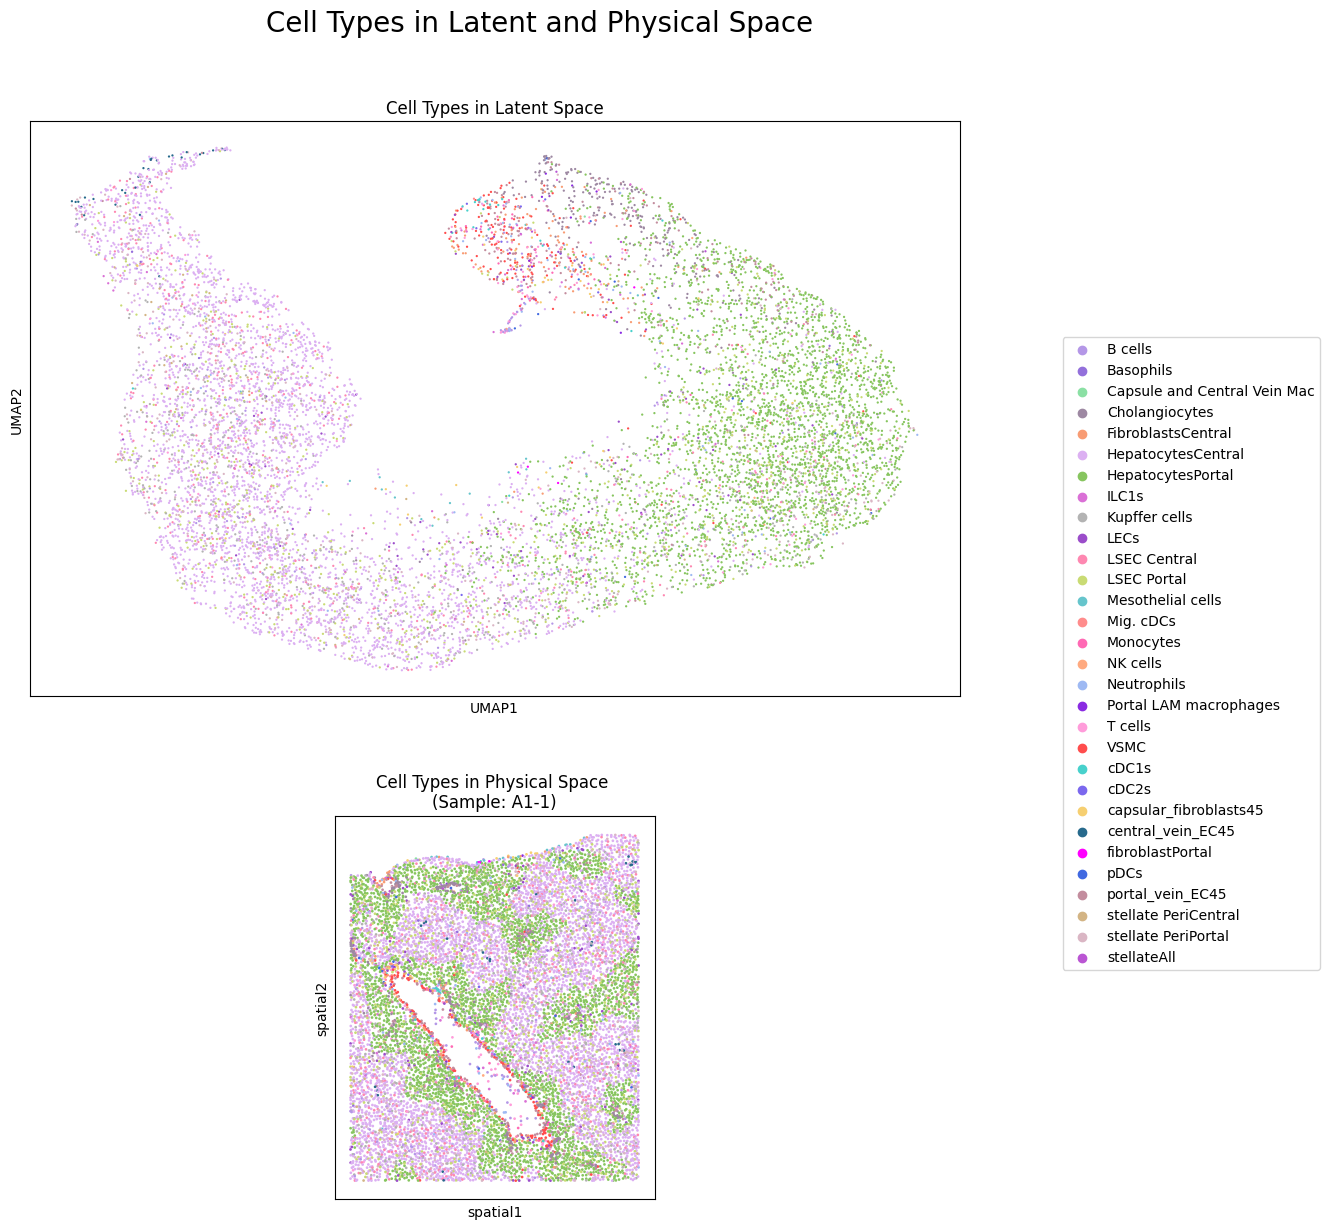

In [28]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### Plot Niches on the latent space

Compute latent Leiden clustering

In [24]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [25]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

Plot the latent and physical space niches.

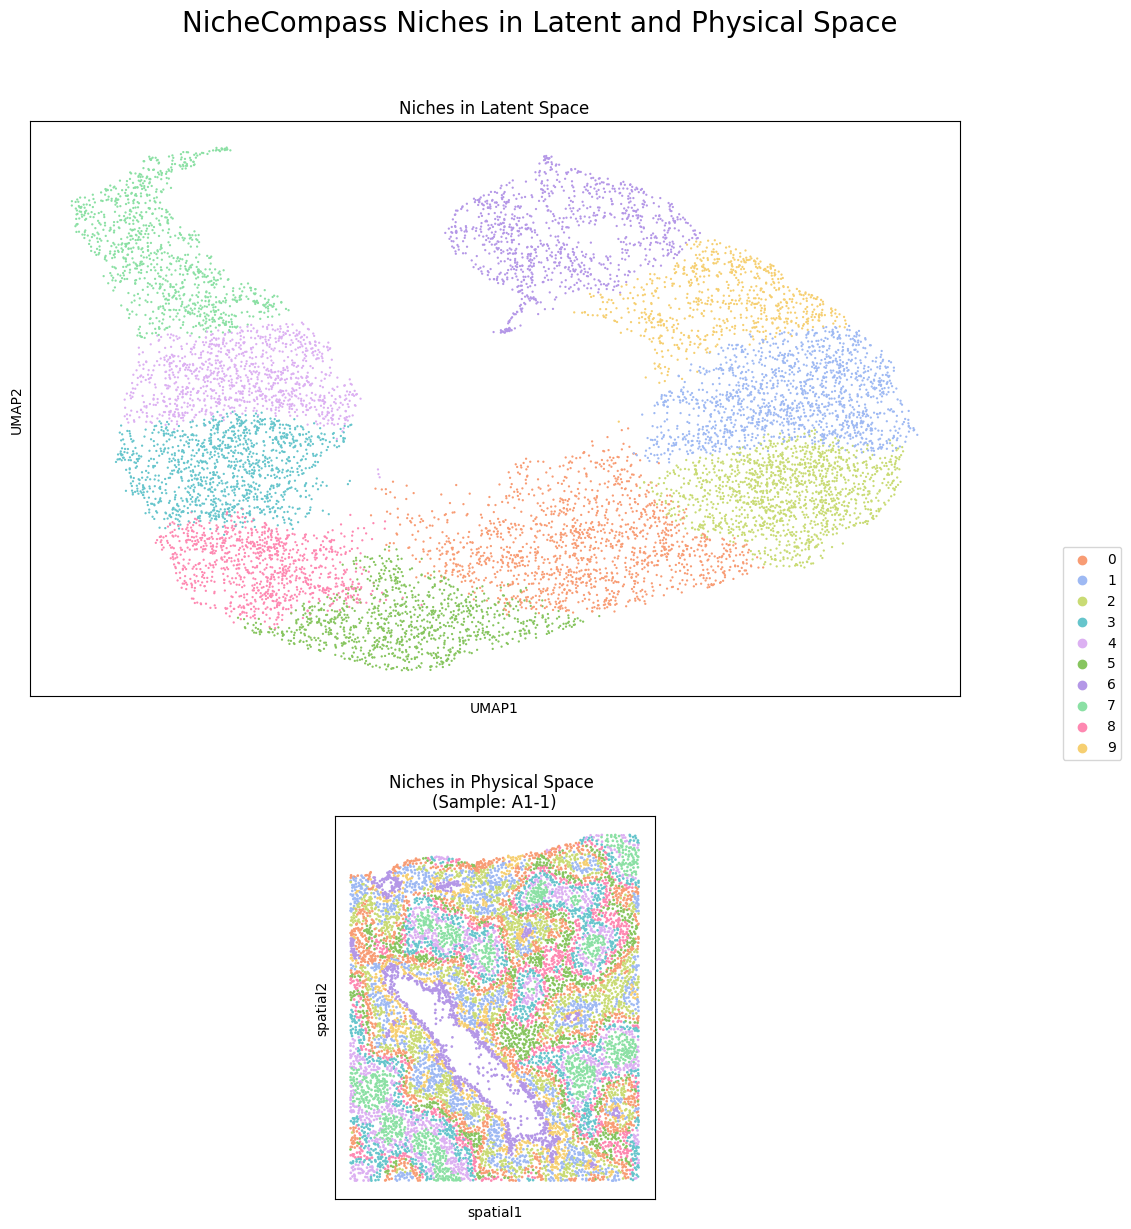

In [31]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

## Characterize Niches

### Niche Composition

In [28]:
import plotly.express as px
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.html"

df_counts = model.adata.obs.groupby([latent_cluster_key, cell_type_key]).size().to_frame().reset_index()
df_counts.rename(columns={'latent_leiden_0.4':'Niche', 0:'Cell Counts', 'annotationSave':"Cell Type Annotations"}, inplace=True)
fig = px.bar(df_counts, x="Niche", y="Cell Counts", color="Cell Type Annotations")

if save_fig:
    fig.write_html(file_path)

The below shows the full interactive figure that Figure 3.8 was created from.

In [4]:
fig.show()

## Cell-cell communication

### Differential GPs

In [29]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 132.
Number of active gene programs: 132.


In [30]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances
0,HGF_ligand_receptor_GP,0,True,0,1,1,1,1,[Hgf],[Pdgfra],[0.1427],[-0.0827],[0.633],[0.367]
1,VWF_ligand_receptor_GP,1,True,1,1,1,1,1,[Vwf],[Itgb7],[0.1093],[0.1303],[0.4562],[0.5438]
2,Cd14_ligand_receptor_target_gene_GP,2,True,2,1,1,4,4,[Cd14],"[Igfbp3, Fn1, Gdf15, Hgf]",[-0.0709],"[-0.3931, 0.3778, 0.2089, -0.1692]",[0.0581],"[0.3223, 0.3097, 0.1712, 0.1387]"
3,Cd209a_ligand_receptor_target_gene_GP,3,True,3,1,1,7,7,[Cd209a],"[Fn1, Col1a1, Igfbp3, Gdf15, Wt1, Spp1, Krt19]",[-0.0208],"[-0.4191, 0.1359, 0.1143, -0.0816, -0.0582, -0...",[0.0242],"[0.4878, 0.1581, 0.133, 0.095, 0.0677, 0.0278,..."
4,Cd5l_ligand_receptor_target_gene_GP,4,True,4,1,1,4,4,[Cd5l],"[Acta2, Igfbp3, Cxcl12, Marco]",[0.0062],"[-0.1864, -0.1487, 0.0468, 0.0201]",[0.0152],"[0.4566, 0.3643, 0.1147, 0.0491]"


In [31]:
# Set parameters for differential gp testing
selected_cats = ["0"]      # None for testing across all
comparison_cats = "rest"    # Specify eg. ["0"] to compare to specific niche
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [32]:
# Run differential gp testing
enriched_gps_10 = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [33]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,0,Add-on_4_GP,0.044802,0.955198,-3.059672
1,0,Add-on_56_GP,0.046902,0.953098,-3.011668
2,0,Add-on_51_GP,0.952783,0.047217,3.004644
3,0,Add-on_15_GP,0.952271,0.047729,2.993311
4,0,Add-on_6_GP,0.054567,0.945433,-2.852219
5,0,Add-on_72_GP,0.939774,0.060226,2.747533
6,0,Epcam_ligand_receptor_target_gene_GP,0.938622,0.061378,2.727355
7,0,Add-on_88_GP,0.936337,0.063663,2.688376
8,0,Add-on_18_GP,0.063785,0.936215,-2.686319
9,0,Add-on_7_GP,0.933403,0.066597,2.640179


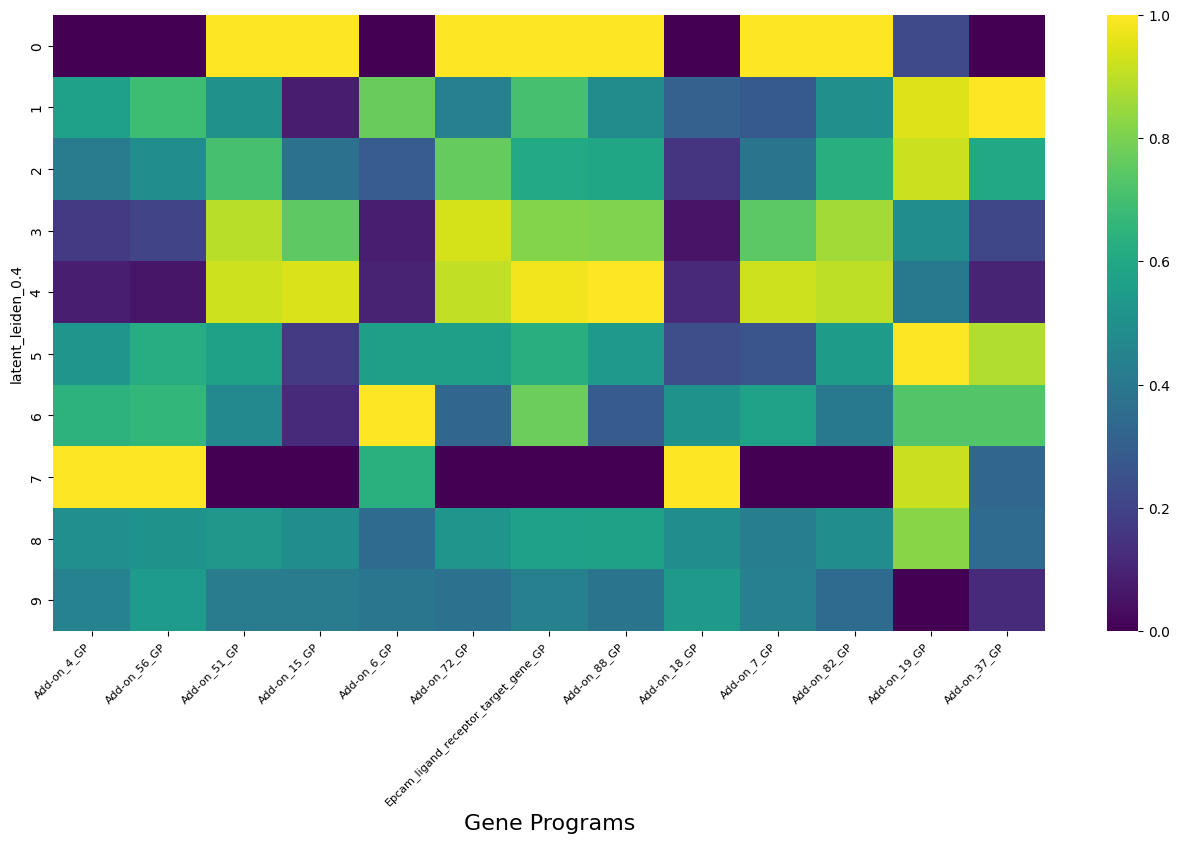

In [34]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps_10].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_10_heatmap.svg",
            bbox_inches="tight")

### Differential GP - All Comparisons

In [47]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [48]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [49]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,7,Add-on_83_GP,0.999214,0.000786,7.147882
1,6,LPL_ligand_receptor_target_gene_GP,0.998971,0.001029,6.878069
2,7,Add-on_19_GP,0.998477,0.001523,6.485659
3,7,Add-on_89_GP,0.002069,0.997931,-6.178583
4,7,Add-on_2_GP,0.002345,0.997655,-6.053048
...,...,...,...,...,...
218,8,Add-on_3_GP,0.089125,0.910875,-2.324366
219,6,Add-on_40_GP,0.089877,0.910123,-2.315142
220,8,Add-on_41_GP,0.909971,0.090029,2.313279
221,2,Add-on_35_GP,0.909127,0.090873,2.303024


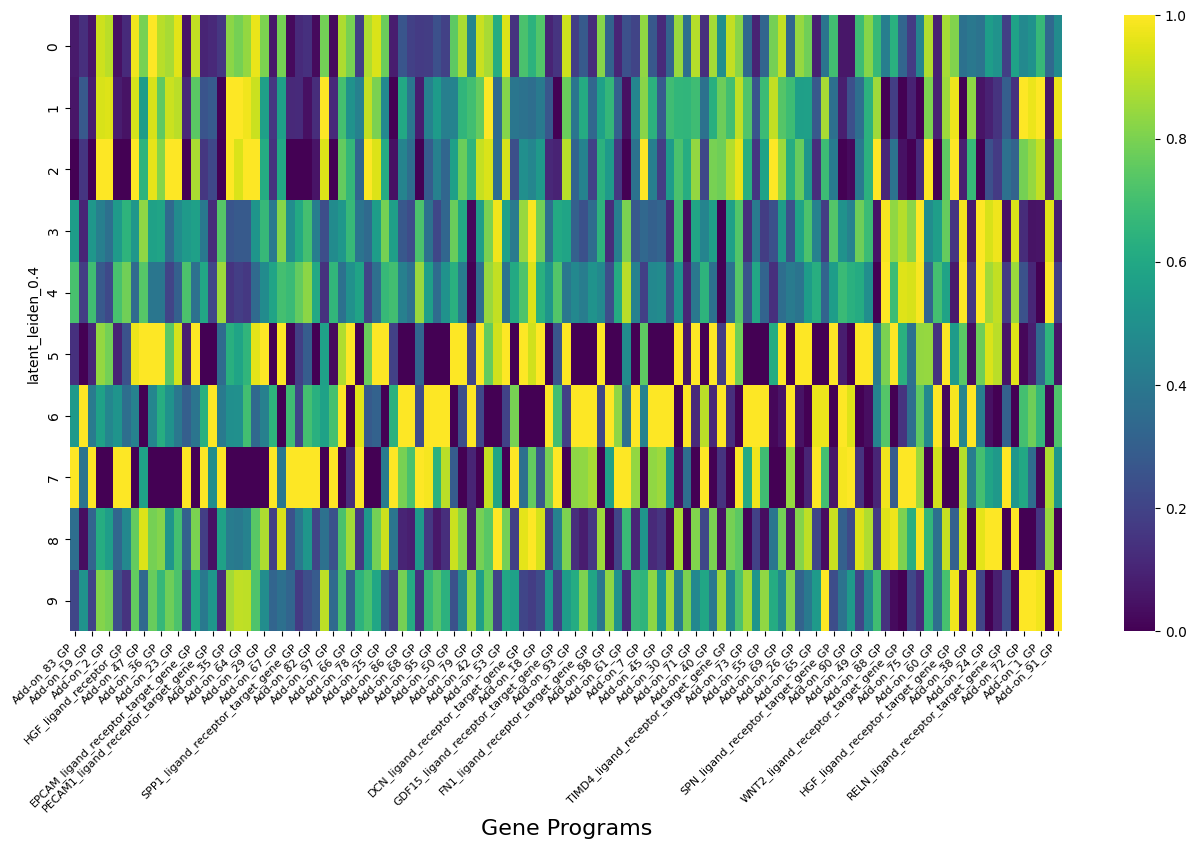

In [50]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

### Communication for COL1A1 GP

In [ ]:
gp_name = 'COL1A1_ligand_receptor_target_gene_GP'

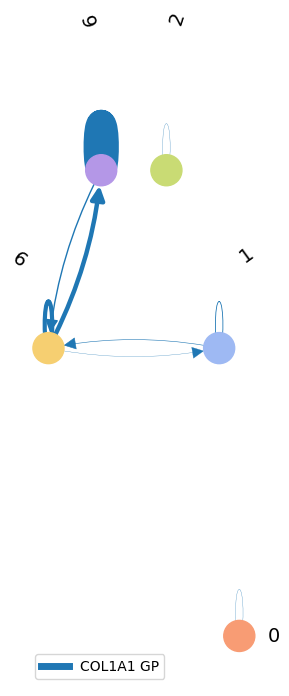

In [ ]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )

### Communication for LPL GP

In [53]:
gp_name = 'LPL_ligand_receptor_target_gene_GP'

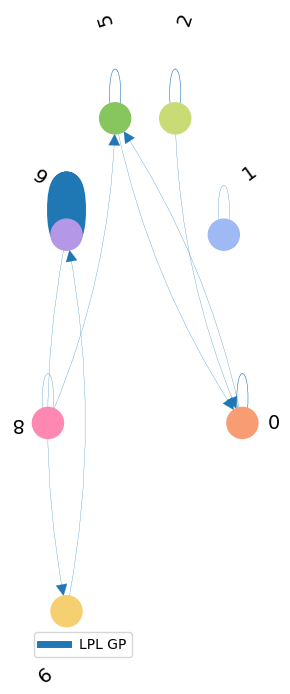

In [54]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )